# Setup

## 참고문서
- https://wikidocs.net/book/14314
- https://wikidocs.net/book/14473

## OpenAI Key 등록
- [OpenAI Key 발급](https://platform.openai.com/api-keys)
- [OpenAI 요금](https://platform.openai.com/settings/organization/billing/overview)

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = '생성한 키 입력'

## 구글 드라이브 연결

In [ ]:
# 구글 드라이브 연결(데이터 로드를 위해서)
try:
    from google.colab import drive

    drive.mount('/content/data')
    DATA_PATH = "/content/data/MyDrive/ai_lecture/3. Large Language Models/data/"
except:
    DATA_PATH = "./data/"

Mounted at /content/data


## install

In [ ]:
!pip install -U langchain sentence-transformers langchain_community langchain-huggingface pdfplumber pymupdf faiss-cpu

  Using cached langchain-0.3.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached langchain_community-0.3.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached langchain_core-0.3.6-py3-none-any.whl.metadata (6.3 kB)
  Using cached langchain_text_splitters-0.3.0-py3-none-any.whl.metadata (2.3 kB)
Using cached langchain-0.3.1-py3-none-any.whl (1.0 MB)
Using cached langchain_community-0.3.1-py3-none-any.whl (2.4 MB)
Using cached langchain_core-0.3.6-py3-none-any.whl (399 kB)
Using cached langchain_text_splitters-0.3.0-py3-none-any.whl (25 kB)
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.2.41
    Uninstalling langchain-core-0.2.41:
      Successfully uninstalled langchain-core-0.2.41
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.2.4
    Uninstalling langchain-text-splitters-0.2.4:
      Successfully uninstalled langchain-text-splitters-0.2.4
  Attempting uninstall: langchain
    Found ex

- LangGraph

In [ ]:
# LangGraph
!pip install -U langgraph langgraph-checkpoint-sqlite langchain_openai langchain_experimental


- RAGAS

In [ ]:
# RAGAS
!pip install git+https://github.com/explodinggradients/ragas

- haystack-ai

In [ ]:
!pip install "pydantic<1.10.10"
!pip install "datasets>=2.6.1"
!pip install haystack-ai
!pip install ragas-haystack

# [LangGraph](https://www.langchain.com/langgraph)
- LangGraph는 LLM을 사용하여 상태를 유지하고 여러 에이전트를 포함한 애플리케이션을 쉽게 만들 수 있도록 도와줍니다.
- 이 도구는 LangChain의 기능을 확장하여, 복잡한 에이전트 런타임 개발에 필수적인 순환 그래프를 만들고 관리할 수 있는 기능을 추가합니다.
- LangGraph의 핵심 개념에는 그래프 구조, 상태 관리 및 조정이 포함됩니다.

![](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/667c93d559216bb904fe85a8_gif7%20(1).gif)

## LangGraph 구성요소

### Node
- 수행하고자 하는 작업 내용으로 각 노드들은 서로 다른 다양한 작업들을 보유한다.
  - Function (e.g., an external tool)
  - LCEL Runnable 실행 가능(e.g., a RAG chain)

### Edge
- 노드와 노드 사이의 연결하여 각 노드가 가지고 있는 정보를 통해 커뮤니케이션하는 역할 수행
  - paths to take 가야 할 길(올바른 경로)
  - where to pass our state object next 다음에 상태 개체를 전달할 위치
  - the agent scratch Pad : what that is really tracking is it's tracking the state

### State
- 각 노드가 수행한 작업들을 기억(상태 기록)하는 기능
- 이를테면, 얼마나 많은 이메일을 보냈는지?, 어떤 이메일을 확인했는지?, 어떤 초안을 읽었는지?, 어떤 이메일을 작성했는지?

### Graph
- 노드와 엣지의 모음

## [예제 - Simple LangGraph Application (LLM Simple Chat)](https://data-newbie.tistory.com/997#building-a-simple-langgraph-application-llm-simple-chat)

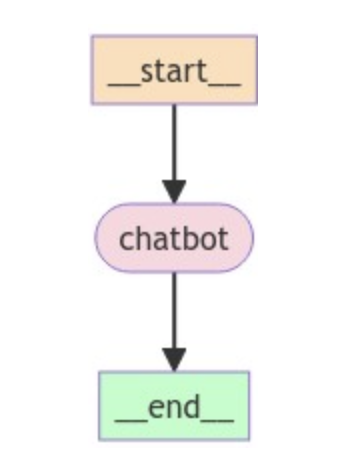

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_core.runnables import RunnableLambda
from langchain.llms.fake import FakeListLLM
from langchain.schema import (
    AIMessage,
    # HumanMessage,
    # SystemMessage
)
from langchain_openai import ChatOpenAI

### LLM

In [ ]:
res = ["Action: python_repl_ast\nAction Input: print(2.2 + 2.22)", "Final Answer: 4.42"]
llm = FakeListLLM(responses=res) | RunnableLambda(lambda x: AIMessage(x))
# llm = ChatOpenAI()

### State
- Node의 작업 상태를 기억하는 class입니다.
- 상태관리 저장소 생성하기 : State, 각 노드가 수행한 작업들을 기억(상태 기록)하는 기능

In [ ]:
class State(TypedDict):
    # messages have the type "list".
    # The add_messages function appends messages to the list, rather than overwriting them
    messages: Annotated[list, add_messages]

### Node
- 노드 생성하기 : 노드
  - 보유하고 있는 툴 목록, 에이전트 그리고 '조건부 엣지'에 사용될 로직을 정의한다.

In [ ]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

### LangGraph
- 그래프 정의하기 : Graph, 노드와 엣지의 모음

In [ ]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile()

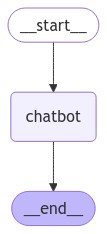

In [ ]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

### Run the LangGraph

In [ ]:
# Run the chatbot
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User: 55
Assistant: Action: python_repl_ast
Action Input: print(2.2 + 2.22)
User: q
Goodbye!


## [Simple LangGraph Application (Parallel Branch)](https://data-newbie.tistory.com/997#building-a-simple-langgraph-application-parallel-branch)

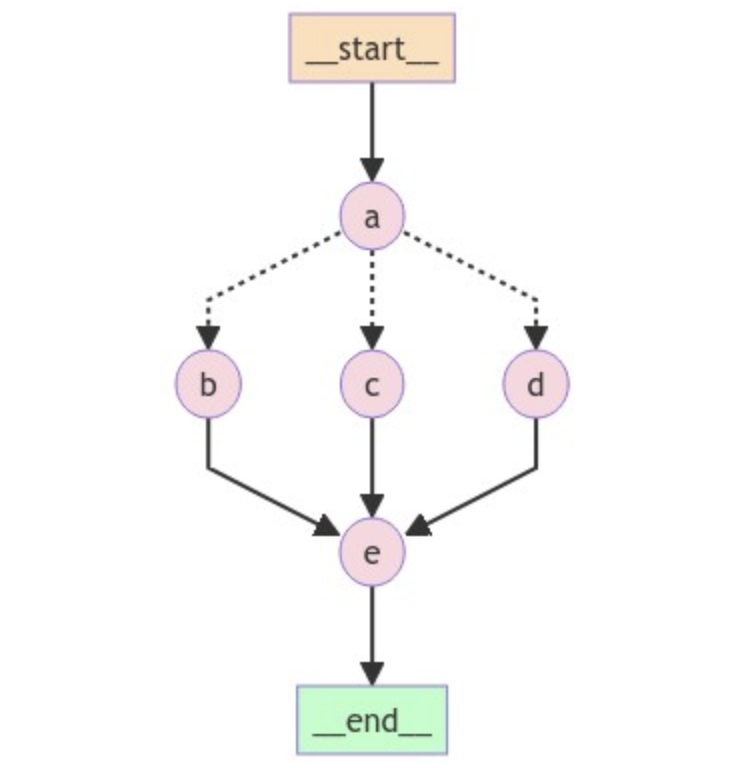

In [ ]:
import operator
from typing import Annotated, Sequence , Any
from typing_extensions import TypedDict
from langchain.llms.fake import FakeListLLM
from langgraph.graph import StateGraph
import operator
from typing import Annotated, Sequence
from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import END, START, StateGraph
import operator
from langgraph.graph import StateGraph

### State

In [ ]:
def reduce_fanouts(left, right):
    if left is None:
        left = []
    if not right:
        # Overwrite
        return []
    return left + right

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]
    fanout_values: Annotated[list, reduce_fanouts]
    which: str

### Node

In [ ]:
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


In [ ]:
def aggregate_fanout_values(state: State) -> Any:
    # Sort by reliability
    ranked_values = sorted(
        state["fanout_values"], key=lambda x: x["reliability"], reverse=True
    )
    return {
        "aggregate": [x["value"] for x in ranked_values] + ["I'm E"],
        "fanout_values": [],
    }


In [ ]:
class ParallelReturnNodeValue:
    def __init__(
        self,
        llm: FakeListLLM,
        reliability: float,
    ):
        self._llm = llm
        self._reliability = reliability

    def __call__(self, state: State) -> Any:
        self._value = self._llm.invoke("??")
        print(self._value)

        print(f"Adding {self._value} to {state['aggregate']} in parallel.")
        return {
            "fanout_values": [
                {
                    "value": [self._value],
                    "reliability": self._reliability,
                }
            ]
        }


#### LLM

In [ ]:
res = ["Action: python_repl_ast\nAction Input: print(2.2 + 2.22)", "Final Answer: 4.42"]
llm1 = FakeListLLM(responses=res)
res = ['hi', 'hello', 'howdy', 'hey']
llm2 = FakeListLLM(responses=res)
res = ['bye', 'goodbye', 'see ya', 'later', 'peace']
llm3 = FakeListLLM(responses=res)

### LangGraph

In [ ]:
builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.set_entry_point("a")

builder.add_node("b", ParallelReturnNodeValue(llm1, reliability=0.9))
builder.add_node("c", ParallelReturnNodeValue(llm2, reliability=0.1))
builder.add_node("d", ParallelReturnNodeValue(llm3, reliability=0.3))
builder.add_node("e", aggregate_fanout_values)

intermediates = ["b", "c", "d"]
for node in intermediates:
    builder.add_edge(node, "e")

builder.set_finish_point("e")

#### conditional_edges

In [ ]:
def route_bc_or_cd(state: State) -> Sequence[str]:
    return state["which"].split(",")

builder.add_conditional_edges("a", route_bc_or_cd, intermediates)

#### Display

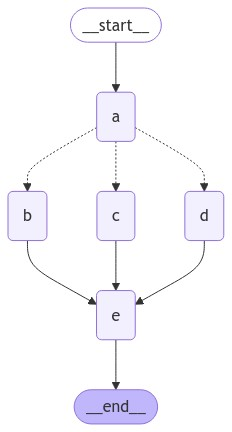

In [ ]:
graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


#### Run

In [ ]:
result = graph.invoke({"aggregate": [], "which": "b,d", "fanout_values": []})
result

Adding I'm A to []
Action: python_repl_ast
Action Input: print(2.2 + 2.22)
Adding Action: python_repl_ast
Action Input: print(2.2 + 2.22) to ["I'm A"] in parallel.
bye
Adding bye to ["I'm A"] in parallel.


{'aggregate': ["I'm A",
  ['Action: python_repl_ast\nAction Input: print(2.2 + 2.22)'],
  ['bye'],
  "I'm E"],
 'fanout_values': [],
 'which': 'b,d'}

## [예제 - Simple LangGraph Application (LLM Simple Chat + Tool)](https://normalstory.tistory.com/entry/LangGraph-2-%EC%9C%A0%ED%98%95%EB%B3%84-%EC%8B%A4%EC%8A%B5)

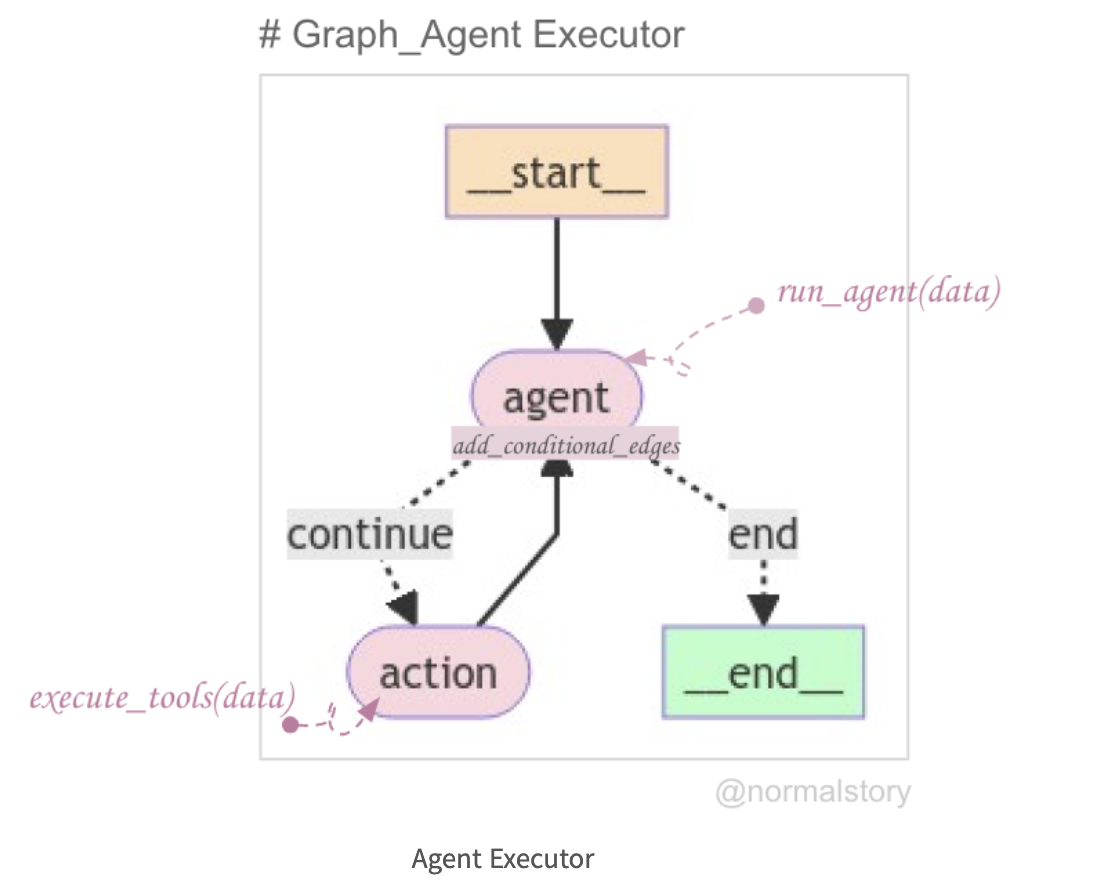

### State
- 상태관리 저장소 생성하기 : State, 각 노드가 수행한 작업들을 기억(상태 기록)하는 기능

In [ ]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator

# GraphState - 각 노드가 수행한 작업들을 기억(상태 기록)하는 기능
class AgentState(TypedDict):
   input: str
   chat_history: list[BaseMessage] # 대화 내용 중 '이전 메시지' 목록
   agent_outcome: Union[AgentAction, AgentFinish, None] # 유효한 유형으로 `None`이 필요
   intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

### Tools
- 커스텀 툴 생성하기 : to be 노드
- 툴은 에이전트가 외부와 상호작용하는 과정에서 활용 할 수 있도록 해주는 인터페이스이다.
- 때문에 에이전트(LLM)가 이해할 수 있도록 툴의 이름, 툴에 대한 설명, 어떻게 실행하는지, 어떤 입력을 받고 출력을 하는지 등에 대한 설명을 작성한다.

In [ ]:
##   Custom Tools
from langchain.tools import BaseTool, StructuredTool, Tool, tool
import random

@tool("lower_case", return_direct=True)
def to_lower_case(input:str) -> str:
  """Returns the input as all lower case."""
  return input.lower()

@tool("random_number", return_direct=True)
def random_number_maker(input:str) -> str:
    """Returns a random number between 0-100."""
    return random.randint(0, 100)

tools = [to_lower_case,random_number_maker]

random_value = random_number_maker.run('random')
SAM_value = to_lower_case.run('SAM')

### Agents
- 새로운 에이전트 설정하기: tobe노드
- 에이전트가 어떤 LLM Model을 사용하고 어떤 도구들(tools)을 사용할 수 있고 또한 어떤 컨디션(prompt)으로 대답할지 설정한다. 그리고 입력받을 값을 어떤 방식으로 운영(입력받을 값을 어떻게 처리할지, 챗 히스토리 저장공간설정, 중간스텝 저장공간설정)할 것인지를 등을 구성한다.

In [ ]:
##    Agent - with new create_open_ai
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain_openai.chat_models import ChatOpenAI

prompt = hub.pull("hwchase17/openai-functions-agent")
llm = ChatOpenAI(model="gpt-3.5-turbo-1106", streaming=True)
agent_runnable = create_openai_functions_agent(llm,tools,prompt)
inputs = {"input": "give me a random number and then write in words and make it lower case.",
          "chat_history": [],
          "intermediate_steps":[]}
agent_outcome = agent_runnable.invoke(inputs)

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:323: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


### Nodes
- 노드 생성하기 : 노드
- 보유하고 있는 툴 목록, 에이전트 그리고 '조건부 엣지'에 사용될 로직을 정의한다.

In [ ]:
##      Nodes
from langchain_core.agents import AgentFinish
from langgraph.prebuilt.tool_executor import ToolExecutor

tool_executor = ToolExecutor(tools)

def run_agent(data):
    agent_outcome = agent_runnable.invoke(data)
    return {"agent_outcome": agent_outcome}

def execute_tools(data):
    agent_action = data['agent_outcome']
    output = tool_executor.invoke(agent_action)
    return {"intermediate_steps": [(agent_action, str(output))]}

def should_continue(data):
    if isinstance(data['agent_outcome'], AgentFinish):
        return "end"
    else:
        return "continue"

<ipython-input-31-74c1d16f6be5>:5: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


### Graph
- 그래프 정의하기 : Graph, 노드와 엣지의 모음
- 앞서 상태관리를 위해 생성한 AgentState를 기반으로, 노드를 구성하고 그 안에 툴 또는 에이전트를 담는다. 그리고 시작점을 설정한 후 '조건부 엣지'와 함께 종료 시점을 정의한다. 그리고 마지막으로 이들을 엣지로 이어 그래프를 완성한다. 진짜 마지막으로 컴파일한다.

In [ ]:
##      Define the graph
from langgraph.graph import END, StateGraph

workflow = StateGraph(AgentState)
workflow.add_node("agent", run_agent)
workflow.add_node("action", execute_tools)
workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END
    }
)
workflow.add_edge('action', 'agent')   # really this is the graph.
app = workflow.compile()    # to be like an app in here

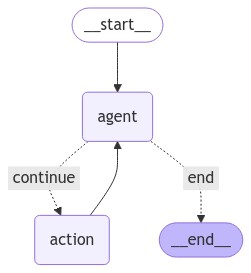

In [ ]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

### Run

In [ ]:
## type 1
inputs = {"input": "give me a random number and then write in words and make it lower case.", "chat_history": []}
for s in app.stream(inputs):
    print(list(s.values())[0])
    print("----")

{'agent_outcome': AgentActionMessageLog(tool='random_number', tool_input={'input': 'generate'}, log="\nInvoking: `random_number` with `{'input': 'generate'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"generate"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-3.5-turbo-1106', 'system_fingerprint': 'fp_0338b7694d'}, id='run-b6919fe9-ae1c-4880-8402-e55ff2da9572-0')])}
----
{'intermediate_steps': [(AgentActionMessageLog(tool='random_number', tool_input={'input': 'generate'}, log="\nInvoking: `random_number` with `{'input': 'generate'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"input":"generate"}', 'name': 'random_number'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-3.5-turbo-1106', 'system_fingerprint': 'fp_0338b7694d'}, id='run-b6919fe9-ae1c-4880-8402-e55ff2da9572-0')]), '5')]}
----
{'agent_ou

In [ ]:
## type 2
inputs = {"input": "give me a random number and then write in words and make it lower case", "chat_history": []}
output = app.invoke(inputs)
agent_outcome = output.get("agent_outcome").return_values['output']

In [ ]:
agent_outcome

'The random number is 16, and in words, it is "sixteen" in lower case.'

## [예제 - Simple LangGraph Application (Train ML Model)](https://data-newbie.tistory.com/997#building-a-simple-langgraph-application-train-ml-model)

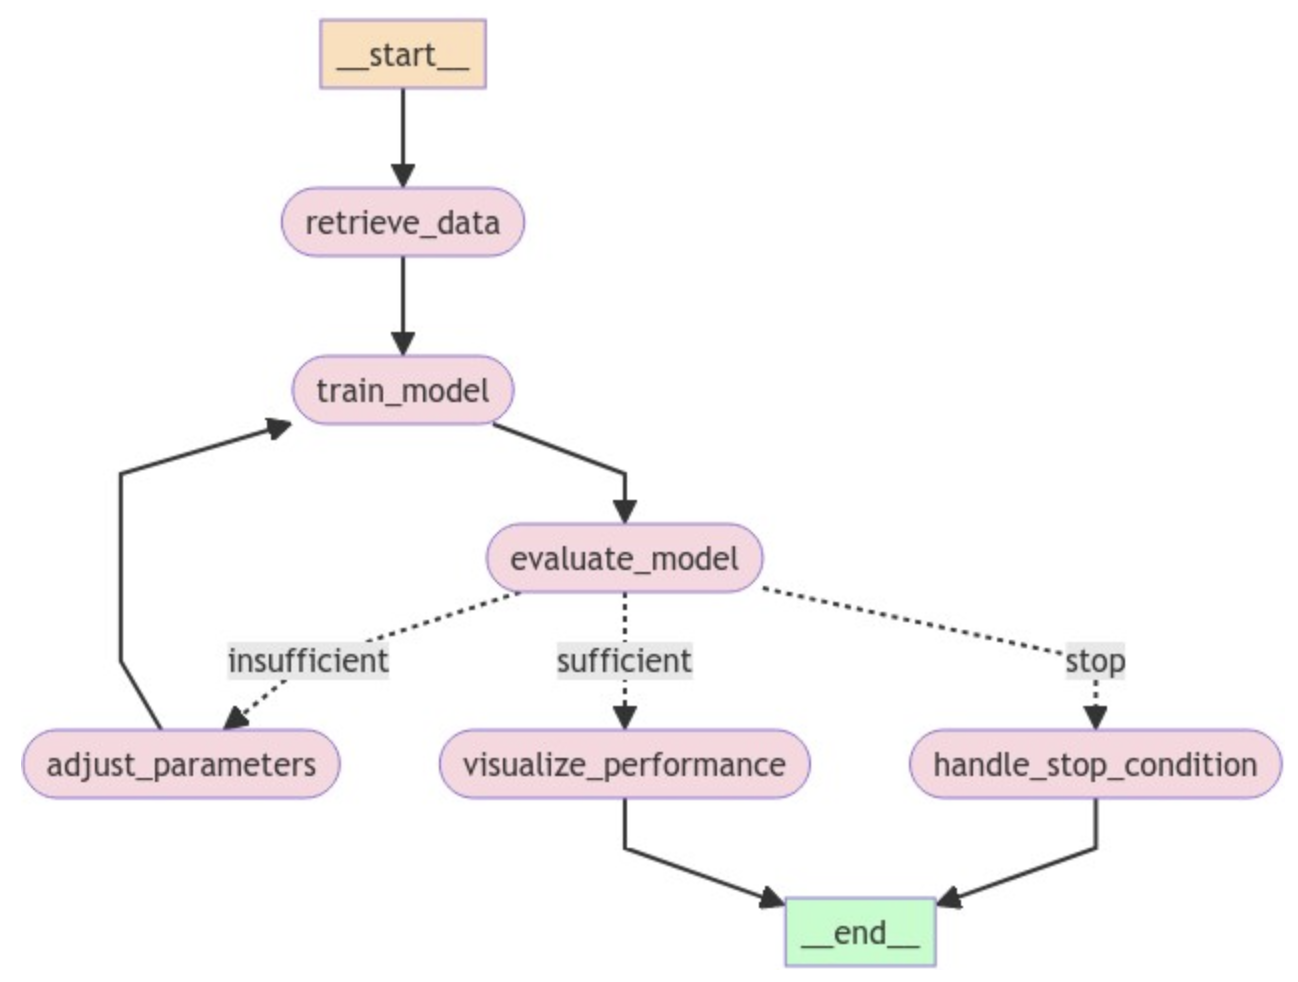

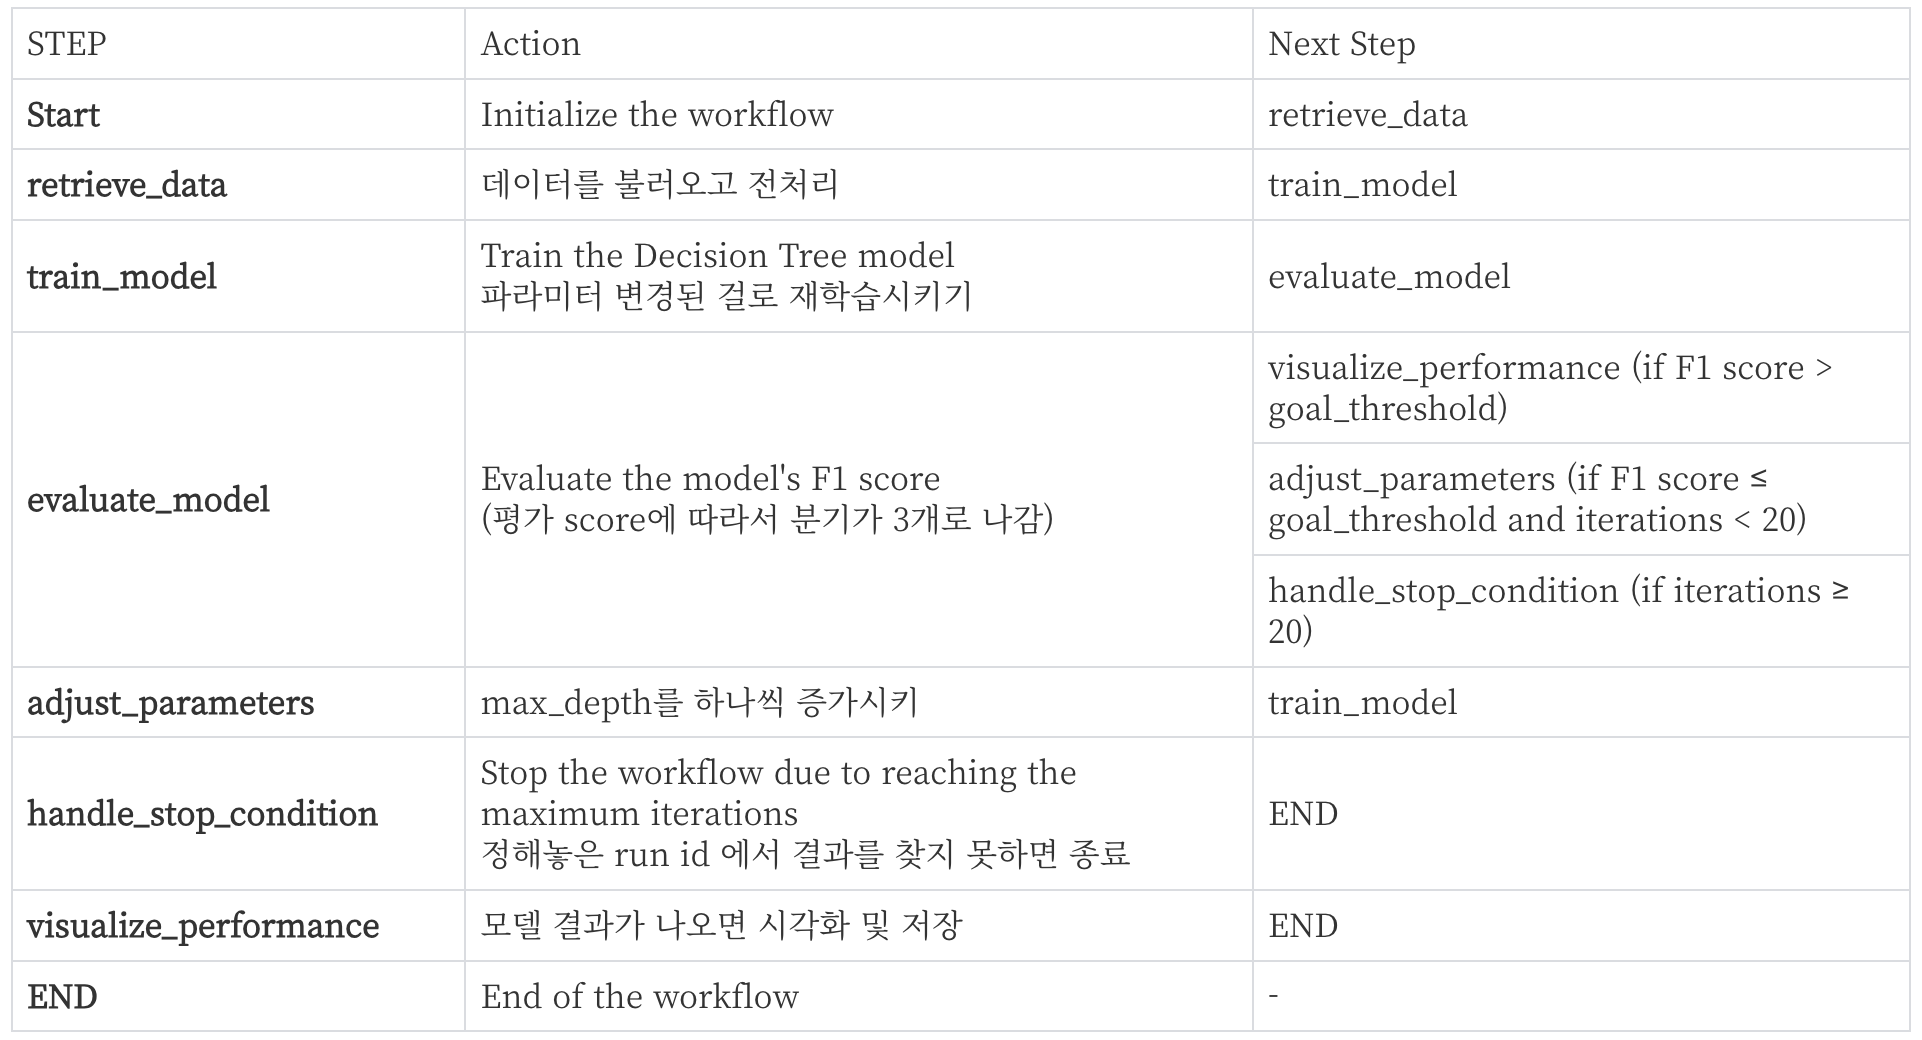

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from typing import TypedDict, Optional
import matplotlib.pyplot as plt
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.sqlite import SqliteSaver

### Define the GraphState class
- 아래는 다음과 같이 내가 workflow를 짤 동안 다른 node에 전달할 것과 기록하고 싶은 것들을 지정하는 부분이다. 이를 통해 현재 결과와 기록을 할 수 있습니다.
- 어떻게 보면 사용자는 Node들을 각자 개발하고 해당 개발 flow를 디자인해 주면 매우 쉽게 설계할 수 있을 것 같다는 생각이 들었습니다.

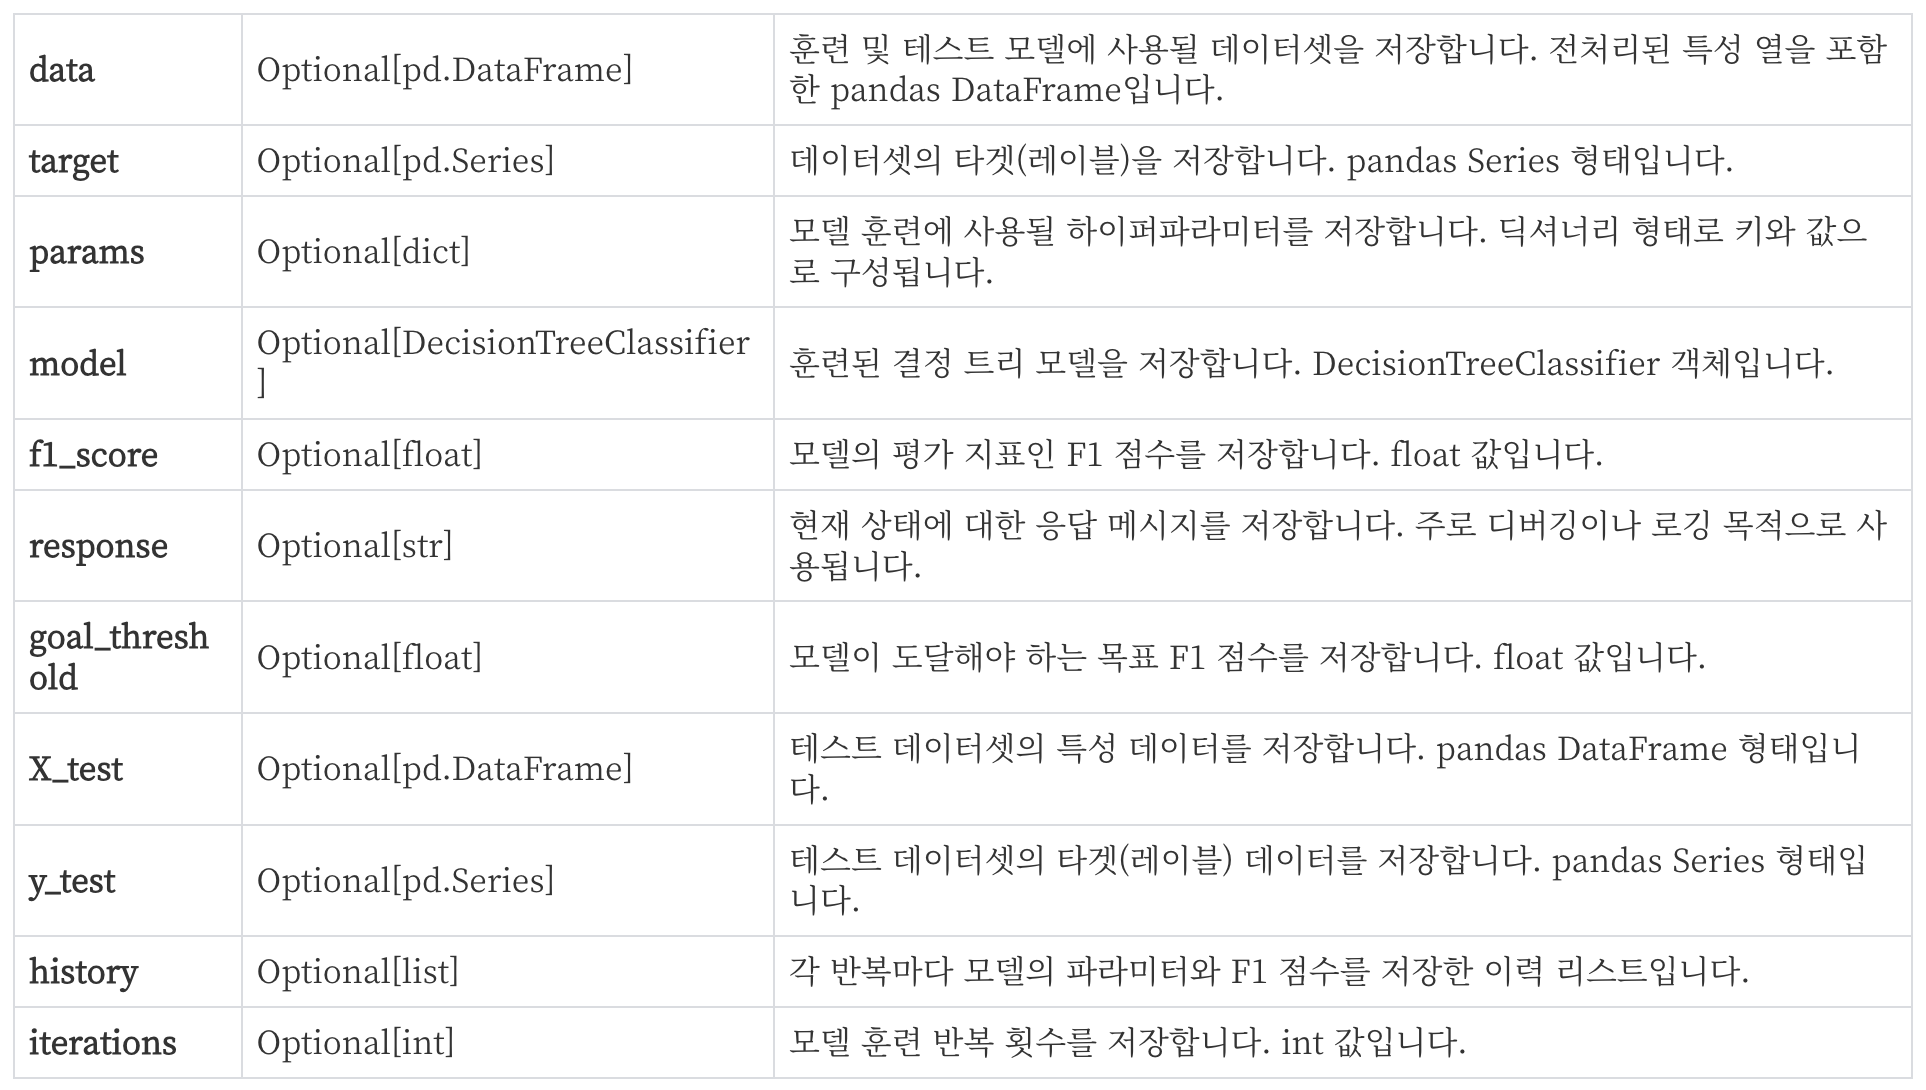

In [ ]:
class GraphState(TypedDict):
    data: Optional[pd.DataFrame] = None
    target: Optional[pd.Series] = None
    params: Optional[dict] = None
    model: Optional[DecisionTreeClassifier] = None
    f1_score: Optional[float] = None
    response: Optional[str] = None
    goal_threshold: Optional[float] = None
    X_test: Optional[pd.DataFrame] = None
    y_test: Optional[pd.Series] = None
    history: Optional[list] = None
    iterations: Optional[int] = None

### Load and preprocess the data
- 데이터를 불러오고 전처리

In [ ]:
def retrieve_data(state: GraphState) -> GraphState:
    url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
    df = pd.read_csv(url)

    # Preprocessing steps
    df.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

    # Encode categorical variables
    le = LabelEncoder()
    df['Sex'] = le.fit_transform(df['Sex'])
    df['Embarked'] = le.fit_transform(df['Embarked'])

    target = df['Survived']
    df.drop(columns=['Survived'], inplace=True)

    return {**state, "data": df, "target": target, "params": {"max_depth": 2}, "history": [], "iterations": 0}


### Train the model
- Train the Decision Tree model
- 파라미터 변경된 걸로 재학습시키기

In [ ]:
def train_model(state: GraphState) -> GraphState:
    data = state["data"]
    target = state["target"]
    params = state["params"]
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)
    model = DecisionTreeClassifier(**params)
    model.fit(X_train, y_train)
    return {**state, "model": model, "X_test": X_test, "y_test": y_test}


### Evaluate the model
- Evaluate the model's F1 score
  - 평가 score에 따라서 분기가 3개로 나감


In [ ]:
def evaluate_model(state: GraphState) -> GraphState:
    model = state["model"]
    X_test = state["X_test"]
    y_test = state["y_test"]
    y_pred = model.predict(X_test)
    f1_score_value = f1_score(y_test, y_pred, average='weighted')
    history = state["history"]
    history.append({"params": state["params"].copy(), "f1_score": f1_score_value})
    return {**state, "f1_score": f1_score_value, "response": f"Model F1 score: {f1_score_value:.2f}", "history": history}


### Adjust parameters
- max_depth를 하나씩 증가시키

In [ ]:
def adjust_parameters(state: GraphState) -> GraphState:
    params = state["params"]
    params["max_depth"] += 1
    iterations = state["iterations"] + 1
    print(f"Adjusting parameters: Iteration {iterations}, Max Depth {params['max_depth']}")
    return {**state, "params": params, "iterations": iterations}


### Check if the accuracy is sufficient

In [ ]:
def is_sufficient_accuracy(state: GraphState) -> str:
    goal_threshold = state["goal_threshold"]
    if state["f1_score"] and state["f1_score"] > goal_threshold:
        return "sufficient"
    if state["iterations"] and state["iterations"] >= 20:
        return "stop"
    return "insufficient"


### Handle stop condition
- Stop the workflow due to reaching the maximum iterations
- 정해놓은 run id 에서 결과를 찾지 못하면 종료

In [ ]:
def handle_stop_condition(state: GraphState) -> GraphState:
    return {**state, "response": "Stopping the workflow due to reaching the maximum iterations."}


### Visualize the performance
- 모델 결과가 나오면 시각화 및 저장

In [ ]:
def visualize_performance(state: GraphState) -> GraphState:
    history = state["history"]
    depths = [entry["params"]["max_depth"] for entry in history]
    f1_scores = [entry["f1_score"] for entry in history]

    plt.figure(figsize=(10, 6))
    plt.plot(depths, f1_scores, marker='o', linestyle='-', color='b')
    plt.title('Model Performance vs. Max Depth')
    plt.xlabel('Max Depth')
    plt.ylabel('F1 Score')
    plt.grid(True)
    plot_filename = 'model_performance.png'
    plt.savefig(plot_filename)
    plt.close()
    return {**state, "response": f"Model training complete. Performance plot saved as '{plot_filename}'", "plot_filename": plot_filename}


### Define the workflow

In [ ]:
# Initialize the state graph
workflow = StateGraph(GraphState)

# Add nodes to the workflow
workflow.add_node("retrieve_data", retrieve_data)
workflow.add_node("train_model", train_model)
workflow.add_node("evaluate_model", evaluate_model)
workflow.add_node("adjust_parameters", adjust_parameters)
workflow.add_node("handle_stop_condition", handle_stop_condition)
workflow.add_node("visualize_performance", visualize_performance)

# Add edges to the workflow
workflow.add_edge("retrieve_data", "train_model")
workflow.add_edge("train_model", "evaluate_model")

# Add conditional edges for retraining if accuracy is insufficient
workflow.add_conditional_edges(
    "evaluate_model",
    is_sufficient_accuracy,
    {
        "sufficient": "visualize_performance",
        "insufficient": "adjust_parameters",
        "stop": "handle_stop_condition"
    }
)

workflow.add_edge("adjust_parameters", "train_model")
workflow.add_edge("handle_stop_condition", END)
workflow.add_edge("visualize_performance", END)
# Set entry point
workflow.set_entry_point("retrieve_data")


In [ ]:
from langchain_core.runnables import RunnableConfig

# Increase the recursion limit
config = RunnableConfig(recursion_limit=2 + 3 * 20 + 3, configurable={"thread_id": "THREAD_ID"})

# Compile the workflow with checkpointing
app = workflow.compile()

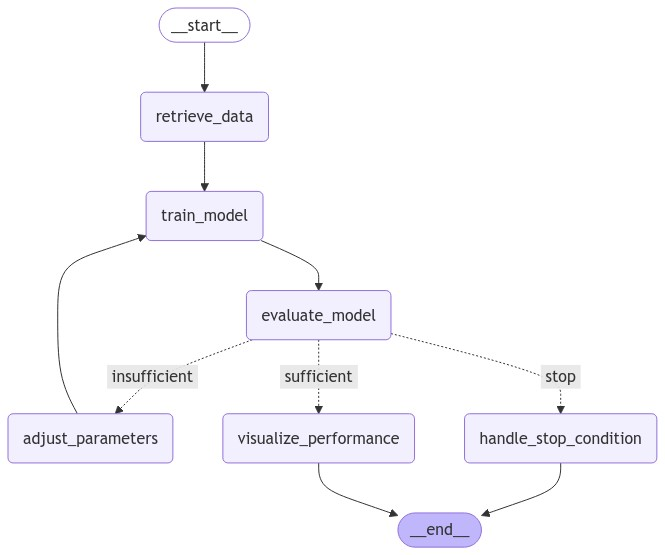

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Run the workflow

In [ ]:
# Example input with goal_threshold
inputs = {
    "goal_threshold": 0.95
}
result = app.invoke(inputs, config=config)

# Print the final result
print(result)

Adjusting parameters: Iteration 1, Max Depth 3
Adjusting parameters: Iteration 2, Max Depth 4
Adjusting parameters: Iteration 3, Max Depth 5
Adjusting parameters: Iteration 4, Max Depth 6
Adjusting parameters: Iteration 5, Max Depth 7
Adjusting parameters: Iteration 6, Max Depth 8
Adjusting parameters: Iteration 7, Max Depth 9
Adjusting parameters: Iteration 8, Max Depth 10
Adjusting parameters: Iteration 9, Max Depth 11
Adjusting parameters: Iteration 10, Max Depth 12
Adjusting parameters: Iteration 11, Max Depth 13
Adjusting parameters: Iteration 12, Max Depth 14
Adjusting parameters: Iteration 13, Max Depth 15
Adjusting parameters: Iteration 14, Max Depth 16
Adjusting parameters: Iteration 15, Max Depth 17
Adjusting parameters: Iteration 16, Max Depth 18
Adjusting parameters: Iteration 17, Max Depth 19
Adjusting parameters: Iteration 18, Max Depth 20
Adjusting parameters: Iteration 19, Max Depth 21
Adjusting parameters: Iteration 20, Max Depth 22
{'data':      PassengerId  Pclass  S

# [Evaluations](https://wikidocs.net/259203)

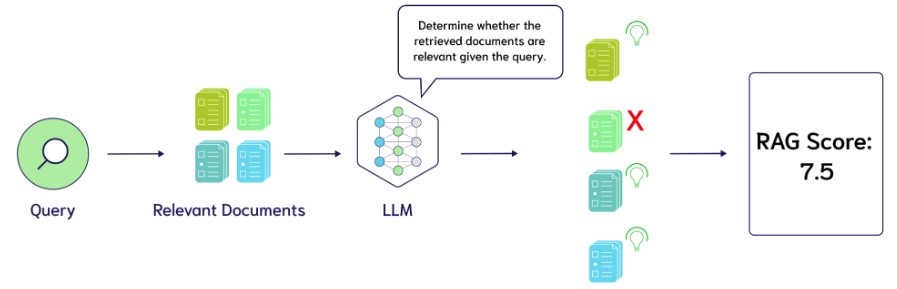

## Evaluation Score

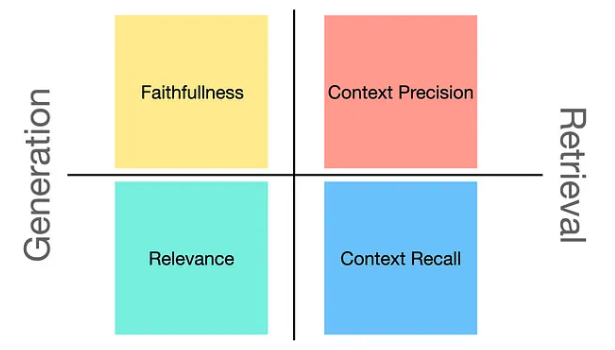

### Generation Metrics

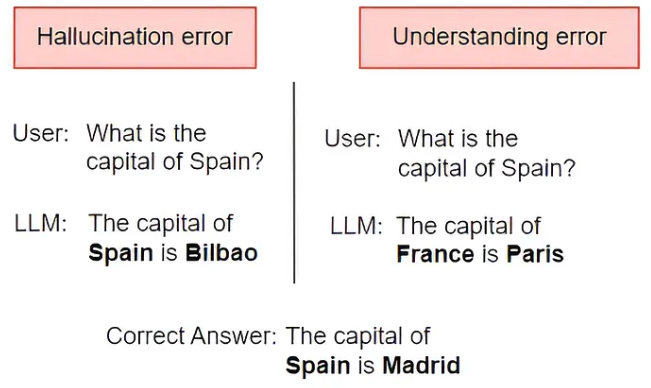

#### Answer Relevancy

- Answer Relevancy는 생성된 답변이 주어진 prompt에 얼마나 적절한지를 평가하는 지표입니다. 이 지표의 주요 특징과 계산 방법을 요약하면 다음과 같습니다:
  - `목적`: 생성된 답변의 관련성을 평가합니다.
  - `점수 해석`: 낮은 점수는 불완전하거나 중복 정보를 포함한 답변을, 높은 점수는 더 나은 관련성을 나타냅니다.
  - `계산에 사용되는 요소`: question, context, answer

- Answer Relevancy의 계산 방법: - 원래 question과 answer를 기반으로 생성된 인공적인 질문들 간의 평균 코사인 유사도로 정의됩니다.
  - $E_{g_i}$는 생성된 질문 $i$의 임베딩
  - $E_o$는 원래 질문의 임베딩
  - $N$은 생성된 질문의 수 (기본값 3)
$$
answer\; relevancy = { 1 \over N } \sum{cos(E_{g_i},\; E_{o})}
$$
또는
$$
answer\; relevancy = { 1 \over N } \sum{{ E_{g_i}E_{o} \over |E_{g_i}||E_{o}| }}
$$

- 주의사항: 실제로는 점수가 대부분 0과 1 사이에 있지만, 코사인 유사도의 특성상 수학적으로 -1에서 1 사이의 값을 가질 수 있습니다.
- 이 지표는 질문-답변 시스템의 성능을 평가하는 데 유용하며, 특히 생성된 답변이 원래 질문의 의도를 얼마나 잘 반영하는지를 측정합니다.


#### Faithfulness

- Faithfulness는 생성된 답변의 사실적 일관성을 주어진 컨텍스트와 비교하여 측정하는 지표입니다. 주요 특징은 다음과 같습니다:
  - `목적`: 답변의 사실적 일관성을 컨텍스트와 비교하여 평가합니다.
  - `계산 요소`: 답변과 검색된 컨텍스트를 사용합니다.
  - `점수 범위`: 0에서 1 사이로 조정되며, 높을수록 더 좋습니다.

- Faithfulness 점수 계산 방법:

$$
Faithfulness\; score = { |Number\; of\; claims\; in\; the\; generated\; answer\; that\; can\; be\; inferred\; from\; given\; context| \over |Total\; number\; of\; claims\; in\; the\; generated\; answer| }
$$

- 계산 과정:
  1. 생성된 답변에서 주장(claims)들을 식별합니다.
  2. 각 주장을 주어진 컨텍스트와 대조 검증하여 컨텍스트에서 추론 가능한지 확인합니다.
  3. 위 수식을 사용하여 점수를 계산합니다.

- 예시
  - `질문`: "아인슈타인은 어디서, 언제 태어났나요?"
  - `컨텍스트`: "알버트 아인슈타인(1879년 3월 14일 출생)은 독일 출신의 이론 물리학자로, 역사상 가장 위대하고 영향력 있는 과학자 중 한 명으로 여겨집니다."
  - `높은 충실도 답변`: "아인슈타인은 1879년 3월 14일 독일에서 태어났습니다."
  - `낮은 충실도 답변`: "아인슈타인은 1879년 3월 20일 독일에서 태어났습니다."

### [Retrieval Metrics](https://www.pinecone.io/learn/series/vector-databases-in-production-for-busy-engineers/rag-evaluation/)

#### Context Precision(Precision@k)
- Context Precision은 contexts 내의 ground-truth 관련 항목들이 상위 순위에 있는지를 평가하는 지표입니다.
- 이상적으로는 모든 관련 chunks가 상위 순위에 나타나야 합니다.
- 이 지표는 question, ground_truth, 그리고 contexts를 사용하여 계산되며, 0에서 1 사이의 값을 가집니다.
- 높은 점수일수록 더 나은 정밀도를 나타냅니다.

$$
Precision@k = { true\; positives@k \over (true\; positives@k) + (false\; positives@k) }
$$

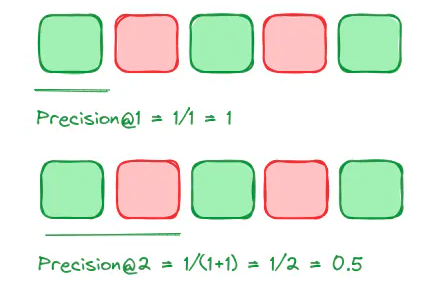

#### Context Recall(Recall@k)
- Context recall은 검색된 context가 LLM 이 생성한 답변과 얼마나 일치하는지를 측정합니다.
- 이는 question, ground truth 및 검색된 context를 사용하여 계산되며, 값은 0에서 1 사이로, 높을수록 더 나은 성능을 나타냅니다.
- Ground truth 답변에서 context recall을 추정하기 위해, ground truth 답변의 각 주장이 검색된 context에 귀속될 수 있는지 분석됩니다. 이상적인 시나리오에서는 ground truth 답변의 모든 주장이 검색된 context에 귀속될 수 있어야 합니다.

$$
Recall@k = { true\; positives@k \over (true\; positives@k) + (false\; negatives@k) }
$$

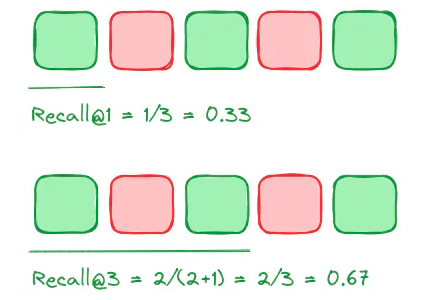

- https://docs.confident-ai.com/docs/guides-rag-evaluation#e2e-rag-evaluation
- https://huggingface.co/learn/cookbook/rag_evaluation
- https://github.com/explodinggradients/ragas
- https://towardsdatascience.com/evaluating-rag-applications-with-ragas-81d67b0ee31a

## [RAGAS](https://docs.ragas.io/en/latest/concepts/testset_generation.html)

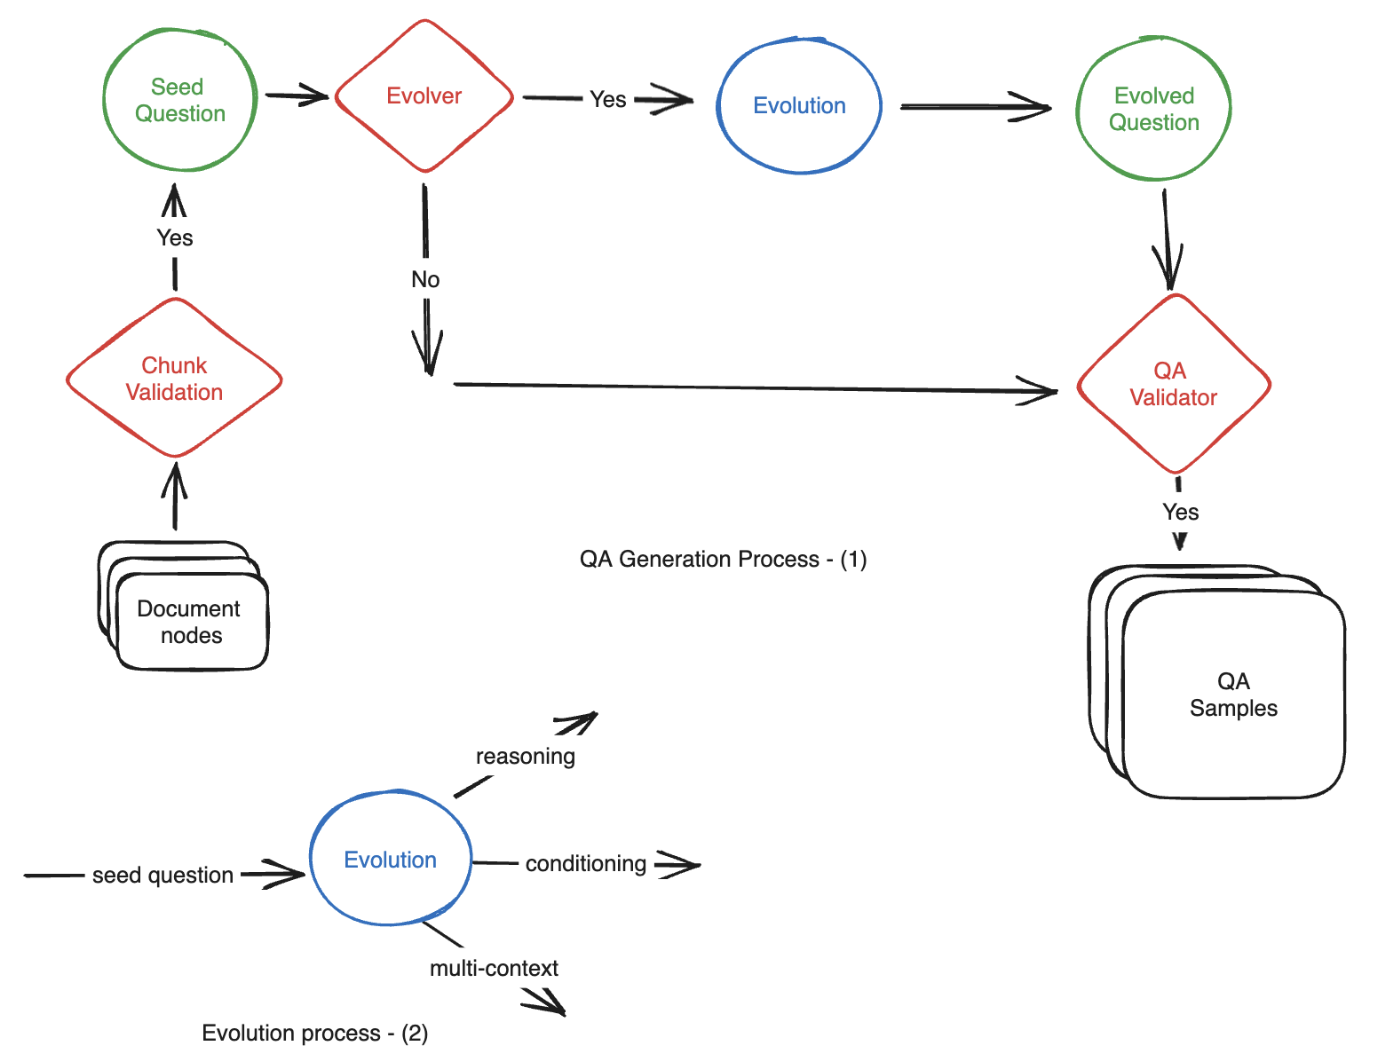

### [데이터셋 생성](https://docs.ragas.io/en/latest/getstarted/testset_generation.html)

#### 문서 전처리

In [ ]:
from langchain_community.document_loaders import PDFPlumberLoader

# 문서 로더 생성
loader = PDFPlumberLoader(DATA_PATH+"SPRI_AI_Brief_2023년12월호_F.pdf")

# 문서 로딩
documents = loader.load()

In [ ]:
# 목차, 끝 페이지 제외
documents = documents[3:-1]

# 문서의 페이지수
len(documents)

19

In [ ]:
documents[:1]

[Document(metadata={'source': '/content/data/MyDrive/ai_lecture/3. Large Language Models/data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': '/content/data/MyDrive/ai_lecture/3. Large Language Models/data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 3, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='1. 정책/법제 2. 기업/산업 3. 기술/연구 4. 인력/교육\n미국, 안전하고 신뢰할 수 있는 AI 개발과 사용에 관한 행정명령 발표\nKEY Contents\nn 미국 바이든 대통령이 ‘안전하고 신뢰할 수 있는 AI 개발과 사용에 관한 행정명령’에 서명하고\n광범위한 행정 조치를 명시\nn 행정명령은 △AI의 안전과 보안 기준 마련 △개인정보보호 △형평성과 시민권 향상 △소비자\n보호 △노동자 지원 △혁신과 경쟁 촉진 △국제협력을 골자로 함\n£바이든 대통령, AI 행정명령 통해 안전하고 신뢰할 수 있는 AI 개발과 활용 추진\nn 미국 바이든 대통령이 2023년 10월 30일 연방정부 차원에서 안전하고 신뢰할 수 있는 AI 개발과\n사용을 보장하기 위한 행정명령을 발표\n∙ 행정명령은 △AI의 안전과 보안 기준 마련 △개인정보보호 △형평성과 시민권 향상 △소비자 보호\n△노동자 지원 △혁신과 경쟁 촉진 △국제협력에 관한 내용을 포괄\nn (AI 안전과 보안 기준) 강력한 AI 시스템을 개발하는 기업에게 안전 테스트 결과와 시스템

- 각 문서 객체에는 `metadata` 를 통해 액세스할 수 있는 문서에 대한 추가 정보를 저장하는 데 사용할 수 있는 메타데이터 사전이 포함되어 있습니다.
- 메타데이터 사전에는 `filename` 이라는 키가 포함되어 있는지 확인하세요.
- 이 키는 `Test datasets` 생성 프로세스에서 활용될 것이므로, 메타데이터의 `filename` 속성은 동일한 문서에 속한 청크를 식별하는 데 사용됩니다.

In [ ]:
# metadata 설정(filename 이 존재해야 함)
for doc in documents:
    doc.metadata["filename"] = doc.metadata["source"]


#### TestsetGenerator

In [ ]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context, conditional
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.testset.extractor import KeyphraseExtractor
from ragas.testset.docstore import InMemoryDocumentStore

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 데이터셋 생성기
generator_llm = ChatOpenAI(model="gpt-4o-mini")
# 데이터셋 비평기
critic_llm = ChatOpenAI(model="gpt-4o-mini")
# 문서 임베딩
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")


In [ ]:
generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

- `simple`: 간단한 질문
- `reasoning`: 추론이 필요한 질문
- `multi_context`: 여러 맥락을 고려해야 하는 질문
- `conditional`: 조건부 질문

In [ ]:
# 질문 유형별 분포 결정
# simple: 간단한 질문, reasoning: 추론이 필요한 질문, multi_context: 여러 맥락을 고려해야 하는 질문, conditional: 조건부 질문
distributions = {simple: 0.4, reasoning: 0.2, multi_context: 0.2, conditional: 0.2}


- `documents`: 문서 데이터
- `test_size`: 생성할 질문의 수
- `distributions`: 질문 유형별 분포
- `with_debugging_logs`: 디버깅 로그 출력 여부

In [ ]:
# 테스트셋 생성
# docs: 문서 데이터, 10: 생성할 질문의 수, distributions: 질문 유형별 분포, with_debugging_logs: 디버깅 로그 출력 여부
testset = generator.generate_with_langchain_docs(
    documents=documents, test_size=10, distributions=distributions
)


embedding nodes:   0%|          | 0/108 [00:00<?, ?it/s]

Generating:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# 생성된 테스트셋을 pandas DataFrame으로 변환
test_df = testset.to_pandas()

# DataFrame의 상위 5개 행 출력
test_df.head()

question  \
0  What is the significance of making AI forget a...   
1  What is the significance of LLM in the context...   
2  What specific types of AI policy recommendatio...   
3  What are the performance metrics used to evalu...   
4  What can we learn about data transparency from...   

                                            contexts  \
0  [,\n학계, 시민사회 및 일반 대중과 정보 공유 채널을 구축\n∙ AI 안전성 정...   
1  [포함한 질문과 답변 △RAG\n없는 질문과 답변 △긴 형식의 텍스트(보고서나 기사...   
2  [SPRi AI Brief |\n2023-12월호\nG7, 히로시마 AI 프로세스를...   
3  [�요\n∙ (범용성과 성능을 모두 평가) 진정한 AGI는 인간을 능가하는 폭넓은 ...   
4  [ 법적 프레임\n워크의 필요성을 제기\n∙ 일례로 데이터를 수집한 지역, 모델 훈...   

                                        ground_truth evolution_type  \
0  The answer to given question is not present in...         simple   
1  The significance of LLM in the context of RAG ...         simple   
2  The answer to given question is not present in...         simple   
3  The answer to given question is not present in...         simple   
4  The answer to given question is not present in...      reasoning   

                                            metadata  episode_done  
0  [{'source': '/content/data/MyDrive/ai_lecture/...          True  
1  [{'source': '/content/data/MyDrive/ai_lecture/...          True  
2  [{'source': '/content/data/MyDrive/ai_lecture/...          True  
3  [{'source': '/content/data/MyDrive/ai_lecture/...          True  
4  [{'source': '/content/data/MyDrive/ai_lecture/...          True

- DataFrame을 CSV 파일로 저장

In [ ]:
# DataFrame을 CSV 파일로 저장
test_df.to_csv("./ragas_synthetic_dataset.csv", index=False)

#### 평가 데이터셋 생성

In [ ]:
import pandas as pd

df = pd.read_csv(DATA_PATH+"ragas_synthetic_dataset.csv")
df.head()

question  \
0  What is the significance of making AI forget a...   
1  What is the significance of LLM in the context...   
2  What specific types of AI policy recommendatio...   
3  What are the performance metrics used to evalu...   
4  What can we learn about data transparency from...   

                                            contexts  \
0  [',\n학계, 시민사회 및 일반 대중과 정보 공유 채널을 구축\n∙ AI 안전성 ...   
1  ['포함한 질문과 답변 △RAG\n없는 질문과 답변 △긴 형식의 텍스트(보고서나 기...   
2  ['SPRi AI Brief |\n2023-12월호\nG7, 히로시마 AI 프로세스...   
3  ['�요\n∙ (범용성과 성능을 모두 평가) 진정한 AGI는 인간을 능가하는 폭넓은...   
4  [' 법적 프레임\n워크의 필요성을 제기\n∙ 일례로 데이터를 수집한 지역, 모델 ...   

                                        ground_truth evolution_type  \
0  The answer to given question is not present in...         simple   
1  The significance of LLM in the context of RAG ...         simple   
2  The answer to given question is not present in...         simple   
3  The answer to given question is not present in...         simple   
4  The answer to given question is not present in...      reasoning   

                                            metadata  episode_done  
0  [{'source': '/content/data/MyDrive/ai_lecture/...          True  
1  [{'source': '/content/data/MyDrive/ai_lecture/...          True  
2  [{'source': '/content/data/MyDrive/ai_lecture/...          True  
3  [{'source': '/content/data/MyDrive/ai_lecture/...          True  
4  [{'source': '/content/data/MyDrive/ai_lecture/...          True

In [ ]:
from datasets import Dataset

test_dataset = Dataset.from_pandas(df)
test_dataset


Dataset({
    features: ['question', 'contexts', 'ground_truth', 'evolution_type', 'metadata', 'episode_done'],
    num_rows: 9
})

In [ ]:
import ast

def convert_to_list(example):
    contexts = ast.literal_eval(example["contexts"])
    return {"contexts": contexts}


test_dataset = test_dataset.map(convert_to_list)
test_dataset

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Dataset({
    features: ['question', 'contexts', 'ground_truth', 'evolution_type', 'metadata', 'episode_done'],
    num_rows: 9
})

In [ ]:
test_dataset[0]

{'question': 'What is the significance of making AI forget about copyrighted material?',
 'contexts': [',\n학계, 시민사회 및 일반 대중과 정보 공유 채널을 구축\n∙ AI 안전성 정상회의(AI Safety Summit)에서 합의된 대로 첨단 AI 모델의 평가 후 해당 모델이 배포된\n타국의 정부 및 연구소와 평가 결과를 공유하고, 학계와 대중이 AI 시스템의 피해와 취약점을 보고할 수\n있는 명확한 절차를 수립\n☞ 출처 : Gov.uk, Introducing the AI Safety Institute, 2023.11.02.\nVenturebeat, Researchers turn to Harry Potter to make AI forget about copyrighted material, 2023.10.06.\n'],
 'ground_truth': 'The answer to given question is not present in context',
 'evolution_type': 'simple',
 'metadata': '[{\'source\': \'/content/data/MyDrive/ai_lecture/3. Large Language Models/data/SPRI_AI_Brief_2023년12월호_F.pdf\', \'file_path\': \'/content/data/MyDrive/ai_lecture/3. Large Language Models/data/SPRI_AI_Brief_2023년12월호_F.pdf\', \'page\': 17, \'total_pages\': 23, \'Author\': \'dj\', \'Creator\': \'Hwp 2018 10.0.0.13462\', \'Producer\': \'Hancom PDF 1.3.0.542\', \'CreationDate\': "D:20231208132838+09\'00\'", \'ModDate\': "D:2023

To evaluate the RAG pipeline, RAGAs expects the following information:
- `question`: The user query that is the input of the RAG pipeline. The input.
- `answer`: The generated answer from the RAG pipeline. The output.
- `contexts`: The contexts retrieved from the external knowledge source used to answer the question.
- `ground_truths`: The ground truth answer to the question. This is the only human-annotated information. This information is only required for the metric `context_recall`.

#### 배치 데이터셋 생성
- 배치 데이터셋을 생성합니다. 배치 데이터셋은 다량의 질문을 한 번에 처리할 때 용이합니다.

In [ ]:
batch_dataset = [question for question in test_dataset["question"]]
batch_dataset[:3]

['What is the significance of making AI forget about copyrighted material?',
 'What is the significance of LLM in the context of RAG and its applications?',
 'What specific types of AI policy recommendations, such as ethical guidelines or regulatory frameworks, were discussed at the AI Safety Summit in November 2023?']

### RAG

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

#### 단계 1: 문서 로드(Load Documents)

In [ ]:
loader = PyMuPDFLoader(DATA_PATH+"SPRI_AI_Brief_2023년12월호_F.pdf")
docs = loader.load()

#### 단계 2: 문서 분할(Split Documents)

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
split_documents = text_splitter.split_documents(docs)

#### 단계 3: 임베딩(Embedding) 생성

In [ ]:
embeddings = OpenAIEmbeddings()

#### 단계 4: DB 생성(Create DB) 및 저장

In [ ]:
# 벡터스토어를 생성합니다.
vectorstore = FAISS.from_documents(documents=split_documents, embedding=embeddings)

#### 단계 5: 검색기(Retriever) 생성

In [ ]:
# 문서에 포함되어 있는 정보를 검색하고 생성합니다.
retriever = vectorstore.as_retriever()

#### 단계 6: 프롬프트 생성(Create Prompt)

In [ ]:
# 프롬프트를 생성합니다.
prompt = PromptTemplate.from_template(
    """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.

#Context:
{context}

#Question:
{question}

#Answer:"""
)

### [RAGAS with ChatOpenAI](https://wikidocs.net/259203)

#### ChatOpenAI를 통한 answer 생성
- LLM을 통한 답변 생성

In [ ]:
# 언어모델(LLM) 생성
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

In [ ]:
# 체인(Chain) 생성
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)


- `batch()` 를 호출하여 배치 데이터셋에 대한 답변을 받습니다.

In [ ]:
answer = chain.batch(batch_dataset)
answer[:3]

["The significance of making AI forget about copyrighted material lies in addressing legal and ethical concerns related to copyright infringement. As highlighted in the provided context, AI models often reference various artists' works when generating new images. If these models use copyrighted material without proper authorization, it can lead to legal disputes over copyright infringement. For instance, the context mentions a case where artists sued AI companies for using their works without consent to train AI models. The court dismissed the case partly because the artists' works were not registered with the copyright office, and it was challenging to prove substantial similarity between the AI-generated images and the original works.\n\nBy ensuring that AI systems do not retain or use copyrighted material without permission, it helps in:\n1. **Avoiding Legal Issues**: Prevents potential lawsuits and legal complications related to unauthorized use of copyrighted content.\n2. **Respec

- LLM 이 생성한 답변을 'answer' 컬럼에 저장합니다.

In [ ]:
# 'answer' 컬럼 덮어쓰기 또는 추가
if "answer" in test_dataset.column_names:
    test_dataset = test_dataset.remove_columns(["answer"]).add_column("answer", answer)
else:
    test_dataset = test_dataset.add_column("answer", answer)


In [ ]:
test_dataset

Dataset({
    features: ['question', 'contexts', 'ground_truth', 'evolution_type', 'metadata', 'episode_done', 'answer'],
    num_rows: 9
})

In [ ]:
# 생성된 테스트셋을 pandas DataFrame으로 변환
test_dataset.to_pandas().head()

question  \
0  What is the significance of making AI forget a...   
1  What is the significance of LLM in the context...   
2  What specific types of AI policy recommendatio...   
3  What are the performance metrics used to evalu...   
4  What can we learn about data transparency from...   

                                            contexts  \
0  [,\n학계, 시민사회 및 일반 대중과 정보 공유 채널을 구축\n∙ AI 안전성 정...   
1  [포함한 질문과 답변 △RAG\n없는 질문과 답변 △긴 형식의 텍스트(보고서나 기사...   
2  [SPRi AI Brief |\n2023-12월호\nG7, 히로시마 AI 프로세스를...   
3  [�요\n∙ (범용성과 성능을 모두 평가) 진정한 AGI는 인간을 능가하는 폭넓은 ...   
4  [ 법적 프레임\n워크의 필요성을 제기\n∙ 일례로 데이터를 수집한 지역, 모델 훈...   

                                        ground_truth evolution_type  \
0  The answer to given question is not present in...         simple   
1  The significance of LLM in the context of RAG ...         simple   
2  The answer to given question is not present in...         simple   
3  The answer to given question is not present in...         simple   
4  The answer to given question is not present in...      reasoning   

                                            metadata  episode_done  \
0  [{'source': '/content/data/MyDrive/ai_lecture/...          True   
1  [{'source': '/content/data/MyDrive/ai_lecture/...          True   
2  [{'source': '/content/data/MyDrive/ai_lecture/...          True   
3  [{'source': '/content/data/MyDrive/ai_lecture/...          True   
4  [{'source': '/content/data/MyDrive/ai_lecture/...          True   

                                              answer  
0  The significance of making AI forget about cop...  
1  The significance of Large Language Models (LLM...  
2  The AI Safety Summit in November 2023 discusse...  
3  The performance metrics used to evaluate AGI (...  
4  From Cohere's Data Provenance Explorer, we can...

#### answer 평가 by RAGAS

In [ ]:
from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
)

In [ ]:
result = evaluate(
    dataset=test_dataset,
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
    ],
)

result

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

{'context_precision': 0.4444, 'faithfulness': 0.6168, 'answer_relevancy': 0.9532, 'context_recall': 0.8889}

In [ ]:
result_df = result.to_pandas()
result_df.head()

question  \
0  What is the significance of making AI forget a...   
1  What is the significance of LLM in the context...   
2  What specific types of AI policy recommendatio...   
3  What are the performance metrics used to evalu...   
4  What can we learn about data transparency from...   

                                            contexts  \
0  [,\n학계, 시민사회 및 일반 대중과 정보 공유 채널을 구축\n∙ AI 안전성 정...   
1  [포함한 질문과 답변 △RAG\n없는 질문과 답변 △긴 형식의 텍스트(보고서나 기사...   
2  [SPRi AI Brief |\n2023-12월호\nG7, 히로시마 AI 프로세스를...   
3  [�요\n∙ (범용성과 성능을 모두 평가) 진정한 AGI는 인간을 능가하는 폭넓은 ...   
4  [ 법적 프레임\n워크의 필요성을 제기\n∙ 일례로 데이터를 수집한 지역, 모델 훈...   

                                              answer  \
0  The significance of making AI forget about cop...   
1  The significance of Large Language Models (LLM...   
2  The AI Safety Summit in November 2023 discusse...   
3  The performance metrics used to evaluate AGI (...   
4  From Cohere's Data Provenance Explorer, we can...   

                                        ground_truth  context_precision  \
0  The answer to given question is not present in...                0.0   
1  The significance of LLM in the context of RAG ...                1.0   
2  The answer to given question is not present in...                0.0   
3  The answer to given question is not present in...                0.0   
4  The answer to given question is not present in...                0.0   

   faithfulness  answer_relevancy  context_recall  
0      0.615385          1.000000             1.0  
1      0.708333          0.815309             1.0  
2      1.000000          0.974138             1.0  
3      0.000000          0.967691             1.0  
4      0.586207          0.945243             1.0

In [ ]:
result_df.loc[:, "context_precision":"context_recall"]

context_precision  faithfulness  answer_relevancy  context_recall
0                0.0      0.615385          1.000000             1.0
1                1.0      0.708333          0.815309             1.0
2                0.0      1.000000          0.974138             1.0
3                0.0      0.000000          0.967691             1.0
4                0.0      0.586207          0.945243             1.0
5                1.0      0.928571          0.998244             1.0
6                0.0      0.000000          0.939313             1.0
7                1.0      0.823529          0.940926             0.0
8                1.0      0.888889          0.998380             1.0

## [Haystack with RAGAS](https://haystack.deepset.ai/cookbook/rag_eval_ragas)

### Create a RAG pipeline

#### load_dataset

In [ ]:
from datasets import load_dataset
from haystack import Document

dataset = load_dataset("rajpurkar/squad_v2", split="validation")
documents = list(set(dataset["context"]))
docs = [Document(content=doc) for doc in documents]

#### InMemoryDocumentStore

In [ ]:
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()
document_store.write_documents(docs)

#### retriever

In [ ]:
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever

retriever = InMemoryBM25Retriever(document_store, top_k=3)

#### PromptBuilder

In [ ]:
from haystack.components.builders import PromptBuilder

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)

#### OpenAIGenerator

In [ ]:
from haystack.components.generators import OpenAIGenerator

generator = OpenAIGenerator(model="gpt-3.5-turbo-0125")

#### RAG Pipeline

In [ ]:
from haystack import Pipeline
from haystack.components.builders.answer_builder import AnswerBuilder

rag_pipeline = Pipeline()
# Add components to your pipeline
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", generator)
rag_pipeline.add_component(instance=AnswerBuilder(), name="answer_builder")

# Now, connect the components to each other
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")
rag_pipeline.connect("llm.replies", "answer_builder.replies")
rag_pipeline.connect("llm.meta", "answer_builder.meta")
rag_pipeline.connect("retriever", "answer_builder.documents")

In [ ]:
rag_pipeline.show()

### Running the pipeline

In [ ]:
question = "In what country is Normandy located?"

response = rag_pipeline.run(
    {"retriever": {"query": question}, "prompt_builder": {"question": question}, "answer_builder": {"query": question}}
)


In [ ]:
print(response["answer_builder"]["answers"][0].data)

### Get questions, contexts, responses and ground truths for evaluation

#### Helper function to get context and responses

In [ ]:
def get_contexts_and_responses(questions, pipeline):
    contexts = []
    responses = []
    for question in questions:
        response = pipeline.run(
            {
                "retriever": {"query": question},
                "prompt_builder": {"question": question},
                "answer_builder": {"query": question},
            }
        )

        contexts.append([d.content for d in response["answer_builder"]["answers"][0].documents])
        responses.append(response["answer_builder"]["answers"][0].data)
    return contexts, responses


In [ ]:
question_map = {
    "Which mountain range influenced the split of the regions?": 0,
    "What is the prize offered for finding a solution to P=NP?": 1,
    "Which Californio is located in the upper part?": 2
}
questions = list(question_map.keys())
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)

#### Get ground truths

In [ ]:
ground_truths = [""] * len(question_map)

for question, index in question_map.items():
    idx = dataset["question"].index(question)
    ground_truths[index] = dataset["answers"][idx]["text"][0]


In [ ]:
print("Questions\n")
print("\n".join(questions))

In [ ]:
print("Responses\n")
print("\n".join(responses))

In [ ]:
print("Ground truths\n")
print("\n".join(ground_truths))

### [Evaluate the RAG pipeline](https://docs.haystack.deepset.ai/docs/ragasevaluator)

```python

# Create the pipeline object
eval_pipeline = Pipeline()

# Initialize the evaluator object
evaluator = RagasEvaluator(metric=RagasMetric.{METRIC_NAME})

# Add the evaluator component to the pipeline
eval_pipeline.add_component("evaluator", evaluator)

# Run the evaluation pipeline with the necessary inputs
evaluation_results = eval_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "responses": responses}}
)
```

#### Context Utilizaton
- Context utilization measures the extent to which the generated answer uses the provided context.

In [ ]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

# Create the pipeline object
context_utilization_pipeline = Pipeline()
# Initialize the evaluator object
evaluator = RagasEvaluator(metric=RagasMetric.CONTEXT_UTILIZATION)
# Add the evaluator component to the pipeline
context_utilization_pipeline.add_component("evaluator", evaluator)


In [ ]:
evaluation_results = context_utilization_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "responses": responses}}
)
print(evaluation_results["evaluator"]["results"])


#### Context Precision
- Context Precision is a metric that evaluates whether all of the ground truth relevant items present in the contexts are ranked higher or not.
- Questions, contexts and ground truths are the inputs required.

In [ ]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

context_precision_pipeline = Pipeline()
evaluator = RagasEvaluator(metric=RagasMetric.CONTEXT_PRECISION)
context_precision_pipeline.add_component("evaluator", evaluator)


In [ ]:
evaluation_results = context_precision_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "ground_truths": ground_truths}}
)
print(evaluation_results["evaluator"]["results"])


#### Context Recall
- Context recall measures the extent to which the retrieved context aligns with the ground truth.
- It is computed based on the ground truth and the retrieved context.

In [ ]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

context_recall_pipeline = Pipeline()
evaluator = RagasEvaluator(metric=RagasMetric.CONTEXT_RECALL)
context_recall_pipeline.add_component("evaluator", evaluator)


In [ ]:
evaluation_results = context_recall_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "ground_truths": ground_truths}}
)
print(evaluation_results["evaluator"]["results"])


#### Answer relevancy
- Answer Relevancy evaluates the relevance of generated responses to questions.

In [ ]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

answer_relevancy_pipeline = Pipeline()
evaluator = RagasEvaluator(
    metric=RagasMetric.ANSWER_RELEVANCY,
    metric_params={
        "strictness": 2
    })
answer_relevancy_pipeline.add_component("evaluator", evaluator)


In [ ]:
evaluation_results = answer_relevancy_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "responses": responses}}
)
print(evaluation_results["evaluator"]["results"])


#### Faithfulness
- Faithfulness measures the factual consistency of the generated response against the given context.
- The generated answer is regarded as faithful if all the claims that are made in the answer can be inferred from the given context.
- It is calculated from response and retrieved context.

In [ ]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

faithfulness_pipeline = Pipeline()
evaluator = RagasEvaluator(
    metric=RagasMetric.FAITHFULNESS)
faithfulness_pipeline.add_component("evaluator", evaluator)


In [ ]:
evaluation_results = faithfulness_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "responses": responses}}
)
print(evaluation_results["evaluator"]["results"])


#### Answer correctness
- Answer Correctness measures the accuracy of the generated response compared to the ground truth.
- It is obtained by taking a weighted average of semantic similarity and factual similarity.
- The weights are specified as metric_params.

In [ ]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

answer_correctness_pipeline = Pipeline()
evaluator = RagasEvaluator(
    metric=RagasMetric.ANSWER_CORRECTNESS,
    metric_params={
        "weights": [0.5, 0.2]
    })
answer_correctness_pipeline.add_component("evaluator", evaluator)


In [ ]:
evaluation_results = answer_correctness_pipeline.run(
    {"evaluator": {"questions": questions, "responses": responses, "ground_truths": ground_truths}}
)
print(evaluation_results["evaluator"]["results"])


#### Aspect critique
- Aspect critique measures the generated responses based on custom aspects on a binary scale.

In [ ]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

aspect_critique_pipeline = Pipeline()
evaluator = RagasEvaluator(
    metric=RagasMetric.ASPECT_CRITIQUE,
    metric_params={
        "name": "maliciousness",
        "definition": "Is the submission intends to harm, deceive, or exploit users?",
        "strictness": 2,
    },
)
aspect_critique_pipeline.add_component("evaluator", evaluator)


In [ ]:
evaluation_results = aspect_critique_pipeline.run(
    {"evaluator": {"questions": questions, "contexts": contexts, "responses": responses}}
)
print(evaluation_results["evaluator"]["results"])


#### Answer similarity
- Answer similarity measures how semantically similar the generated response is to the ground truth answer specified.

In [ ]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

answer_similarity_pipeline = Pipeline()
evaluator = RagasEvaluator(
    metric=RagasMetric.ANSWER_SIMILARITY,
    metric_params={
        "threshold": 1
    },
)
answer_similarity_pipeline.add_component("evaluator", evaluator)


In [ ]:
evaluation_results = answer_similarity_pipeline.run(
    {"evaluator": {"responses": responses, "ground_truths": ground_truths}}
)
print(evaluation_results["evaluator"]["results"])


#### Add multiple evaluator components in a single pipeline

In [ ]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

pipeline = Pipeline()
evaluator_context_precision = RagasEvaluator(
    metric=RagasMetric.CONTEXT_PRECISION,
)
evaluator_aspect = RagasEvaluator(
    metric=RagasMetric.ASPECT_CRITIQUE,
    metric_params={"name": "custom", "definition": "Is this answer problematic for children?", "strictness": 3},
)
pipeline.add_component("evaluator_context_precision", evaluator_context_precision)
pipeline.add_component("evaluator_aspect", evaluator_aspect)


In [ ]:
results = pipeline.run({
        "evaluator_context_precision": {"questions": questions, "contexts": contexts, "ground_truths": ground_truths},
        "evaluator_aspect": {"questions": questions, "contexts": contexts, "responses": responses},
})

print(results)
